In [1]:
# Importar las librerías
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import numpy as np


In [42]:
def Iteration(Neurons):
    List_MSE=[]
    for i in range(1,101):
        dataset = read_csv('Datos_Columna.csv', header=0, index_col=0,nrows=251)
        dataset = dataset[["Acetona %w","Etanol %w","Butanol %w","Reflujo","Carga térmica"]]
        values = dataset.values
        # convert series to supervised learning
        def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
            n_vars = 1 if type(data) is list else data.shape[1]
            df = DataFrame(data)
            cols, names = list(), list()
            # input sequence (t-n, ... t-1)
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            # forecast sequence (t, t+1, ... t+n)
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
            agg = concat(cols, axis=1)
            agg.columns = names
            # drop rows with NaN values
            if dropnan:
                agg.dropna(inplace=True)
            return agg


        # asegurarse de que todos los datos son tipo float
        values = values.astype('float32')
        # normalizar datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        # especificar el número de horas de retrazo
        n_lag = 5
        n_features = 5
        # frame as supervised learning
        reframed = series_to_supervised(scaled, n_lag, 1)
        # Dividir en entrenamiento y prueba
        values = reframed.values
        n_train_index =61
        train = values[:n_train_index, :]
        test = values[n_train_index:, :]
        # Dividir en entradas y salidas
        #CHANGES HERE
        #split into input and outputs
        n_obs = n_lag * n_features
        train_X = train[:, :n_obs]
        train_y = train[:, -n_features:(-n_features+3)] #+2 because of indexing madness.
        test_X = test[:, :n_obs]
        test_y = test[:, -n_features:(-n_features+3)]

        train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

        #CAMBIOS AQUI

        #design network
        model = Sequential()
        model.add(LSTM(5,activation='linear', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
        model.add(LSTM(Neurons, activation='linear'))
        model.add(Dense(3)) 
        model.compile(loss='mse', optimizer='rmsprop')

        #fit network
        history = model.fit(train_X, train_y, epochs=3000, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)

        #make a prediction
        y_hat = model.predict(test_X)

        #CHANGES HERE
        test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
        inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0:3] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions

        #CHANGES HERE
        #invert scaling for actual
        test_y = test_y.reshape((len(test_y),3)) #changed 1 to 2
        inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0:3] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
        #CHANGES HERE
        #calculate RMSE - CHANGED to output RMSE for each variable.

        mse = mean_squared_error(inv_y[:,(0,1,2)], inv_yhat[:,(0,1,2)])
        List_MSE.append(mse)
    return List_MSE

In [43]:
Lista_MSE_1 = Iteration(1)
PROM_MSE_1 = sum(Lista_MSE_1)/len(Lista_MSE_1)
DESV_MSE_1 = np.std(Lista_MSE_1)
print('Lista_MSE_1')
print(Lista_MSE_1)
print('PROM_MSE_1')
print(PROM_MSE_1)
print('DESV_MSE_1')
print(DESV_MSE_1)

Lista_MSE_1
[7.681279e-05, 4.24345e-05, 4.4409553e-05, 8.4872096e-05, 8.104999e-05, 5.1858882e-05, 3.8844995e-05, 6.782123e-05, 2.7091495e-05, 5.921278e-05, 5.8182162e-05, 5.432266e-05, 3.0885585e-05, 6.195765e-05, 8.07295e-05, 5.810278e-05, 6.720524e-05, 4.794562e-05, 6.974502e-05, 6.517787e-05, 4.3571392e-05, 7.579516e-05, 6.485749e-05, 5.4995424e-05, 5.3656968e-05, 6.4571876e-05, 7.439653e-05, 8.4006395e-05, 8.22749e-05, 4.2804222e-05, 8.28109e-05, 7.432967e-05, 7.9450016e-05, 6.4701475e-05, 5.4667395e-05, 5.340864e-05, 5.9171605e-05, 8.0109305e-05, 3.9926173e-05, 7.579668e-05, 4.9912123e-05, 6.0824765e-05, 6.540935e-05, 4.207948e-05, 3.6071644e-05, 4.9059225e-05, 3.292454e-05, 6.9218564e-05, 4.5145935e-05, 3.3312735e-05, 5.269133e-05, 2.5923046e-05, 2.9183722e-05, 6.188977e-05, 7.55248e-05, 7.299879e-05, 7.3888375e-05, 6.862988e-05, 9.622433e-05, 4.1263353e-05, 7.2587405e-05, 7.173706e-05, 5.374776e-05, 3.2961936e-05, 5.9877824e-05, 9.162886e-05, 3.8896087e-05, 6.540381e-05, 5.9404

In [44]:
Lista_MSE_5 = Iteration(5)
PROM_MSE_5 = sum(Lista_MSE_5)/len(Lista_MSE_5)
DESV_MSE_5 = np.std(Lista_MSE_5)
print('Lista_MSE_5')
print(Lista_MSE_5)
print('PROM_MSE_5')
print(PROM_MSE_5)
print('DESV_MSE_5')
print(DESV_MSE_5)

Lista_MSE_5
[1.9063926e-05, 1.529461e-05, 6.05101e-06, 5.4810066e-06, 2.7557175e-05, 1.6978584e-05, 1.0032775e-05, 6.128001e-05, 3.319319e-05, 1.569503e-05, 3.3859596e-05, 7.184757e-06, 2.0339703e-05, 1.0957148e-05, 5.942559e-06, 1.9250796e-05, 1.2083431e-05, 1.0013945e-05, 1.4811872e-05, 2.1719565e-05, 1.1908492e-05, 3.8006347e-06, 1.3965045e-05, 1.0985943e-05, 3.5851237e-05, 1.07591295e-05, 1.6789769e-05, 1.3397548e-05, 1.6570219e-05, 2.0393987e-05, 1.1011359e-05, 1.1869208e-05, 3.1024156e-05, 2.3172703e-05, 7.5341054e-06, 7.563676e-06, 3.707212e-05, 1.2051577e-05, 5.7485286e-06, 8.799e-06, 4.0577197e-05, 8.818289e-06, 3.349927e-05, 1.7278515e-05, 3.8899416e-06, 1.22228885e-05, 4.0722924e-05, 2.1465623e-05, 4.226253e-06, 3.014099e-05, 1.0236095e-05, 4.2819347e-06, 2.6149879e-05, 3.6564636e-06, 1.7180128e-05, 7.0015917e-06, 7.713894e-06, 4.1546333e-05, 1.9886049e-05, 2.7060958e-05, 1.3185577e-05, 1.0873203e-05, 3.7061876e-05, 1.4383196e-05, 1.0515396e-05, 1.1748453e-05, 1.2418391e-05,

In [45]:
Lista_MSE_10 = Iteration(10)
PROM_MSE_10 = sum(Lista_MSE_10)/len(Lista_MSE_10)
DESV_MSE_10 = np.std(Lista_MSE_10)
print('Lista_MSE_10')
print(Lista_MSE_10)
print('PROM_MSE_10')
print(PROM_MSE_10)
print('DESV_MSE_10')
print(DESV_MSE_10)

Lista_MSE_10
[1.3026663e-05, 5.723155e-05, 1.1459223e-05, 1.2557925e-05, 8.239634e-06, 5.4314864e-05, 1.1821285e-05, 1.9325187e-05, 1.9136203e-05, 5.3614126e-06, 1.5435942e-05, 5.1050806e-06, 6.427794e-06, 1.2350375e-05, 6.402259e-06, 1.6010908e-05, 2.9748975e-05, 1.7608681e-05, 1.1913567e-05, 2.7543292e-05, 2.3179628e-05, 2.0722664e-05, 1.6717933e-05, 6.646014e-06, 8.823618e-06, 2.4298737e-05, 1.8660328e-05, 7.470693e-06, 2.4130824e-05, 1.9974372e-05, 4.3509353e-05, 1.0856456e-05, 5.088077e-06, 1.0202953e-05, 1.6515603e-05, 3.8626316e-05, 2.3338414e-05, 9.399523e-06, 1.1987525e-05, 2.4690957e-05, 1.1037621e-05, 4.8625648e-06, 2.8728651e-05, 5.6152094e-06, 1.24450935e-05, 2.0746047e-05, 2.0172713e-05, 3.2744847e-06, 1.591745e-05, 1.8394501e-05, 6.0037496e-06, 4.151634e-05, 8.423428e-06, 3.4974266e-05, 1.4877715e-05, 4.894508e-06, 4.599398e-06, 6.967954e-06, 2.7828657e-06, 9.372165e-06, 8.608496e-06, 9.3695335e-06, 9.464257e-06, 1.8275137e-05, 1.5246314e-05, 8.5051615e-06, 3.930579e-05,

In [46]:
Lista_MSE_15 = Iteration(15)
PROM_MSE_15 = sum(Lista_MSE_15)/len(Lista_MSE_15)
DESV_MSE_15 = np.std(Lista_MSE_15)
print('Lista_MSE_15')
print(Lista_MSE_15)
print('PROM_MSE_15')
print(PROM_MSE_15)
print('DESV_MSE_15')
print(DESV_MSE_15)

Lista_MSE_15
[1.8574634e-05, 9.377712e-06, 5.3204385e-06, 2.5023466e-05, 1.4288043e-05, 1.0148316e-05, 1.9612306e-05, 3.080115e-05, 1.7072078e-05, 3.7588903e-05, 1.7684752e-05, 3.1078875e-05, 6.870096e-06, 7.090332e-06, 6.6604116e-06, 3.28729e-05, 7.4647355e-06, 1.133404e-05, 8.07983e-06, 3.10657e-05, 1.4452348e-05, 4.316945e-05, 2.4087502e-05, 2.4085397e-05, 6.219951e-06, 3.0215231e-05, 6.3976127e-06, 1.398483e-05, 2.2617576e-05, 9.48938e-06, 6.886628e-06, 1.4338664e-05, 6.4829915e-06, 2.71076e-05, 1.41469545e-05, 1.05817935e-05, 1.1698837e-05, 3.522658e-05, 2.529079e-05, 3.510669e-05, 2.045925e-05, 1.35769615e-05, 1.4170625e-05, 5.7575576e-06, 2.514045e-05, 9.7917045e-06, 2.6358599e-05, 5.4477205e-05, 2.3759458e-05, 2.2281924e-05, 9.58152e-06, 3.210288e-05, 3.4238696e-05, 1.7412804e-05, 7.273417e-06, 4.5645545e-05, 2.4801098e-05, 1.4094462e-05, 3.8074304e-05, 2.2204205e-05, 2.9671375e-05, 2.9759745e-05, 1.854797e-05, 1.7485609e-05, 1.2225851e-05, 3.5880665e-05, 7.340061e-06, 8.642090

In [47]:
Lista_MSE_20 = Iteration(20)
PROM_MSE_20 = sum(Lista_MSE_20)/len(Lista_MSE_20)
DESV_MSE_20 = np.std(Lista_MSE_20)
print('Lista_MSE_20')
print(Lista_MSE_20)
print('PROM_MSE_20')
print(PROM_MSE_20)
print('DESV_MSE_20')
print(DESV_MSE_20)

Lista_MSE_20
[3.3266777e-05, 2.7246306e-05, 2.9298617e-05, 3.2086357e-06, 2.3077419e-05, 1.4319289e-05, 1.8614135e-05, 2.1651489e-05, 2.0093303e-05, 1.4077435e-05, 2.3010134e-05, 1.004428e-05, 3.922026e-05, 1.2582629e-05, 4.2268425e-06, 4.32457e-06, 6.9755624e-06, 1.1422851e-05, 6.578882e-06, 1.1672128e-05, 4.000379e-05, 2.0616675e-05, 3.668723e-05, 1.440944e-05, 1.0921079e-05, 5.3510225e-06, 2.7534166e-05, 1.15397115e-05, 2.2386228e-05, 2.4744315e-05, 1.5548234e-05, 8.10499e-06, 8.391192e-06, 1.2137026e-05, 1.2638361e-05, 2.2731117e-05, 9.086333e-06, 2.5222653e-05, 1.742099e-05, 2.5102034e-05, 1.9858644e-05, 8.402322e-06, 1.27923195e-05, 8.996689e-06, 1.6895216e-05, 1.3660872e-05, 2.8949047e-05, 1.38769465e-05, 1.1820607e-05, 2.5174935e-05, 3.343844e-05, 5.428368e-06, 5.266121e-06, 2.6949985e-05, 6.9270354e-06, 4.7012113e-06, 2.3167673e-05, 2.33394e-05, 1.8030085e-05, 1.4273634e-05, 1.3931287e-05, 9.319626e-06, 1.2190761e-05, 1.6293792e-05, 5.380825e-06, 1.169834e-05, 1.982078e-05, 8.

In [48]:
Lista_MSE_25 = Iteration(25)
PROM_MSE_25 = sum(Lista_MSE_25)/len(Lista_MSE_25)
DESV_MSE_25 = np.std(Lista_MSE_25)
print('Lista_MSE_25')
print(Lista_MSE_25)
print('PROM_MSE_25')
print(PROM_MSE_25)
print('DESV_MSE_25')
print(DESV_MSE_25)

Lista_MSE_25
[1.5467616e-05, 1.0468814e-05, 1.7537564e-05, 2.2711894e-05, 1.7480066e-05, 2.2822314e-05, 1.4070202e-05, 1.882854e-05, 1.5541114e-05, 3.3940043e-05, 1.5722233e-05, 5.7987454e-06, 2.4732888e-05, 3.1886637e-05, 1.8522782e-05, 9.120073e-06, 1.26235755e-05, 2.327239e-05, 1.9950445e-05, 4.6327355e-06, 2.8247678e-05, 2.0924177e-05, 6.144169e-05, 1.5810869e-05, 1.7166609e-05, 1.4301935e-05, 3.3236905e-05, 7.966651e-06, 2.5314248e-05, 2.5313062e-05, 1.7694001e-05, 2.4866284e-05, 2.0976384e-05, 1.4062781e-05, 9.0103e-06, 2.0284851e-05, 1.6619531e-05, 3.0280004e-05, 3.4176184e-05, 1.4248143e-05, 3.6442525e-05, 5.1483917e-06, 2.2441147e-05, 6.7305555e-05, 3.525099e-05, 2.0937392e-05, 1.04215205e-05, 3.4233864e-05, 1.8992214e-05, 1.5899717e-05, 3.2992426e-05, 1.945807e-05, 1.8944207e-05, 3.8734365e-06, 2.1478632e-05, 1.1766534e-05, 1.7890432e-05, 1.5953512e-05, 1.5662268e-05, 2.1154236e-05, 3.9238173e-05, 1.5311278e-05, 3.3618457e-05, 1.4530965e-05, 7.132059e-06, 2.1115831e-05, 1.188

In [49]:
Lista_MSE_30 = Iteration(30)
PROM_MSE_30 = sum(Lista_MSE_30)/len(Lista_MSE_30)
DESV_MSE_30 = np.std(Lista_MSE_30)
print('Lista_MSE_30')
print(Lista_MSE_30)
print('PROM_MSE_30')
print(PROM_MSE_30)
print('DESV_MSE_30')
print(DESV_MSE_30)

Lista_MSE_30
[8.339915e-06, 3.4416993e-05, 2.0861371e-05, 1.45920085e-05, 2.2894694e-05, 6.963422e-06, 1.7841798e-05, 1.4946517e-05, 1.2167122e-05, 9.690629e-06, 2.5352378e-05, 1.14032955e-05, 1.2190717e-05, 1.2649438e-05, 1.27317335e-05, 6.6820467e-06, 2.6472038e-05, 1.6209777e-05, 4.8781108e-06, 1.8514329e-05, 9.748679e-06, 1.9600924e-05, 2.5921605e-05, 6.6693106e-06, 1.0824396e-05, 3.0147072e-05, 2.192318e-05, 1.4035449e-05, 1.02249205e-05, 8.914188e-06, 6.6971515e-06, 4.075242e-05, 1.8562294e-05, 2.6841999e-05, 1.3557932e-05, 6.6608045e-06, 1.106007e-05, 8.809845e-06, 3.2655942e-05, 9.761082e-06, 9.487671e-06, 2.5846623e-05, 3.7800335e-05, 2.3920424e-05, 4.1305284e-06, 1.9810313e-05, 2.2534778e-05, 9.98968e-06, 1.5348469e-05, 8.113132e-06, 1.5526999e-05, 2.2315608e-05, 1.2630951e-05, 9.777824e-06, 7.5462635e-06, 1.8662378e-05, 2.0822712e-05, 1.6913433e-05, 3.7418184e-05, 1.3474743e-05, 3.614433e-05, 1.1518681e-05, 1.3234197e-05, 1.75152e-05, 1.1803661e-05, 3.592068e-05, 1.7882743e-

In [50]:
Lista_MSE_35 = Iteration(35)
PROM_MSE_35 = sum(Lista_MSE_35)/len(Lista_MSE_35)
DESV_MSE_35 = np.std(Lista_MSE_35)
print('Lista_MSE_35')
print(Lista_MSE_35)
print('PROM_MSE_35')
print(PROM_MSE_35)
print('DESV_MSE_35')
print(DESV_MSE_35)

Lista_MSE_35
[2.0087205e-05, 9.24687e-06, 2.1627302e-05, 6.581653e-06, 1.0364936e-05, 1.9266941e-05, 7.922613e-06, 5.0489933e-05, 1.9291389e-05, 1.0801093e-05, 3.841985e-05, 2.5318526e-05, 1.01480555e-05, 3.608785e-05, 7.349266e-05, 1.2590772e-05, 3.1345906e-05, 1.3707165e-05, 3.2019194e-05, 7.528182e-06, 2.3233746e-05, 1.4603814e-05, 1.5813821e-05, 2.1257909e-05, 8.094312e-06, 1.6794194e-05, 2.043204e-05, 2.0379526e-05, 1.4728178e-05, 7.1583604e-06, 4.3372336e-05, 3.4442884e-05, 1.6397711e-05, 1.3295078e-05, 4.3455733e-05, 1.2578338e-05, 8.401986e-06, 2.7823897e-05, 1.02036765e-05, 2.181479e-05, 4.8299746e-05, 2.1958824e-05, 1.60412e-05, 2.5517358e-05, 2.2542694e-05, 8.079572e-06, 2.6427188e-05, 5.399033e-06, 9.386476e-06, 5.3154654e-05, 4.918456e-06, 3.189444e-05, 2.3044357e-05, 1.5843741e-05, 7.748517e-06, 1.2006451e-05, 9.766404e-06, 2.4099436e-05, 1.0960393e-05, 1.8539691e-05, 1.19552315e-05, 4.4488283e-06, 4.9957766e-06, 1.7644625e-05, 8.5075735e-06, 6.9025186e-06, 3.4481298e-05,

In [51]:
Lista_MSE_40 = Iteration(40)
PROM_MSE_40 = sum(Lista_MSE_40)/len(Lista_MSE_40)
DESV_MSE_40 = np.std(Lista_MSE_40)
print('Lista_MSE_40')
print(Lista_MSE_40)
print('PROM_MSE_40')
print(PROM_MSE_40)
print('DESV_MSE_40')
print(DESV_MSE_40)

Lista_MSE_40
[1.20992145e-05, 2.4271663e-05, 9.346529e-06, 1.6423528e-05, 1.1954654e-05, 9.755532e-06, 2.5399213e-05, 2.583274e-05, 8.0488e-06, 1.3538131e-05, 1.111383e-05, 2.9265777e-05, 1.741464e-05, 1.203606e-05, 2.3235183e-05, 1.6842007e-05, 1.3801294e-05, 1.33132535e-05, 6.9352277e-06, 1.8597038e-05, 2.551922e-05, 1.5604337e-05, 2.1532238e-05, 1.0668853e-05, 1.3296347e-05, 3.1616455e-05, 1.4572913e-05, 2.7559096e-05, 1.6805832e-05, 2.5012918e-05, 1.1765304e-05, 2.3199138e-05, 3.2091873e-05, 1.9288495e-05, 2.1569342e-05, 1.3035659e-05, 1.2531141e-05, 2.3210878e-05, 4.0774856e-05, 3.3789634e-05, 2.411005e-05, 1.9070505e-05, 2.0533756e-05, 3.198824e-05, 4.9728355e-06, 3.9678845e-05, 1.625372e-05, 2.2306833e-05, 2.5250001e-05, 1.9160087e-05, 1.533837e-05, 2.1178019e-05, 1.8395272e-05, 2.0949577e-05, 1.0307785e-05, 1.2598691e-05, 4.211826e-06, 2.4162307e-05, 2.3093315e-05, 2.8486385e-05, 1.8928993e-05, 1.7838958e-05, 1.1490112e-05, 1.4546019e-05, 6.893073e-06, 1.8544944e-05, 1.2013493e

In [52]:
Lista_MSE_45 = Iteration(45)
PROM_MSE_45 = sum(Lista_MSE_45)/len(Lista_MSE_45)
DESV_MSE_45 = np.std(Lista_MSE_45)
print('Lista_MSE_45')
print(Lista_MSE_45)
print('PROM_MSE_45')
print(PROM_MSE_45)
print('DESV_MSE_45')
print(DESV_MSE_45)

Lista_MSE_45
[1.3042649e-05, 1.2466909e-05, 9.190838e-06, 1.2929005e-05, 2.0453926e-05, 3.0389952e-05, 1.6698848e-05, 1.957838e-05, 2.6773485e-05, 1.7752687e-05, 2.6607318e-05, 1.3072736e-05, 3.7140802e-05, 9.892092e-06, 1.2146946e-05, 3.039678e-05, 1.843811e-05, 9.265261e-06, 3.8875656e-05, 2.1865431e-05, 7.5938424e-06, 1.1002024e-05, 1.4697852e-05, 1.0363219e-05, 1.3873483e-05, 5.480308e-06, 2.5079515e-05, 1.880709e-05, 3.36869e-05, 4.963569e-06, 5.0399573e-05, 8.038155e-06, 1.2524423e-05, 8.9115665e-06, 2.6291995e-05, 1.2842291e-05, 1.670077e-05, 8.102939e-06, 1.7831999e-05, 1.23781365e-05, 1.8762637e-05, 1.5174702e-05, 6.845772e-06, 1.1689196e-05, 1.2800766e-05, 1.0450647e-05, 1.4097009e-05, 1.6386899e-05, 2.0247615e-05, 8.705659e-06, 2.4991865e-05, 1.5830783e-05, 1.3842462e-05, 2.5903151e-05, 1.3370266e-05, 1.1833138e-05, 2.9003275e-05, 1.4443052e-05, 1.854564e-05, 7.4380205e-06, 1.4498808e-05, 6.77165e-06, 2.885395e-05, 1.563785e-05, 3.1643005e-05, 3.2899556e-05, 1.4158686e-05, 1

In [53]:
Lista_MSE_50 = Iteration(50)
PROM_MSE_50 = sum(Lista_MSE_50)/len(Lista_MSE_50)
DESV_MSE_50 = np.std(Lista_MSE_50)
print('Lista_MSE_50')
print(Lista_MSE_50)
print('PROM_MSE_50')
print(PROM_MSE_50)
print('DESV_MSE_50')
print(DESV_MSE_50)

Lista_MSE_50
[2.1693724e-05, 1.2858481e-05, 9.071983e-06, 2.5213796e-05, 2.7692768e-05, 1.07946535e-05, 1.5793072e-05, 2.8818284e-05, 2.1312533e-05, 1.655944e-05, 9.3018225e-06, 2.3982246e-05, 2.5042807e-05, 1.3345496e-05, 5.530639e-06, 1.6595888e-05, 2.6914853e-05, 1.1134577e-05, 1.1774143e-05, 2.7938195e-05, 1.2960337e-05, 6.7065243e-06, 1.50408405e-05, 6.7140813e-06, 4.081307e-06, 1.4624834e-05, 1.7852128e-05, 5.143957e-06, 8.183694e-06, 1.2287336e-05, 1.5055222e-05, 1.4241759e-05, 1.0905387e-05, 9.934902e-06, 1.6765165e-05, 1.1999164e-05, 1.093562e-05, 1.125754e-05, 1.2132418e-05, 1.7079092e-05, 3.0002293e-05, 1.6325392e-05, 1.1285829e-05, 2.5252186e-05, 2.1776026e-05, 1.1355616e-05, 2.422439e-05, 1.1072117e-05, 1.0638124e-05, 1.2650756e-05, 5.7993543e-06, 2.3057446e-05, 1.3413933e-05, 2.945718e-05, 1.2218257e-05, 2.394525e-05, 3.0293866e-05, 1.1956879e-05, 4.103407e-05, 5.713178e-06, 1.642317e-05, 2.7764756e-05, 1.1060569e-05, 1.2348787e-05, 9.124587e-06, 9.694514e-06, 2.2613118e-

In [54]:
PROM = [PROM_MSE_1,PROM_MSE_5,PROM_MSE_10,PROM_MSE_15,PROM_MSE_20,PROM_MSE_25,PROM_MSE_30,PROM_MSE_35,PROM_MSE_40,PROM_MSE_45,PROM_MSE_50]
DESV = [DESV_MSE_1,DESV_MSE_5,DESV_MSE_10,DESV_MSE_15,DESV_MSE_20,DESV_MSE_25,DESV_MSE_30,DESV_MSE_35,DESV_MSE_40,DESV_MSE_45,DESV_MSE_50]

In [2]:
PROM=[5.848956900081248e-05, 1.706354720681702e-05, 1.624330882123104e-05, 1.9697220036505314e-05, 1.8947345108699664e-05, 2.040871524513932e-05, 1.909119779156754e-05, 1.8468749581188603e-05, 1.9180938143108505e-05, 1.7976165950130962e-05, 1.649849388286384e-05]
DESV=[1.7966402e-05, 1.2344372e-05, 1.1073417e-05, 1.21101375e-05, 1.2654298e-05, 1.1104764e-05, 1.3528145e-05, 1.2121503e-05, 8.65303e-06, 8.476037e-06, 8.201067e-06]

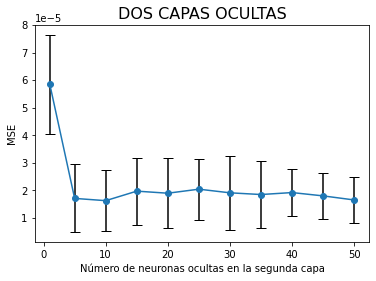

In [4]:
#Gráfico 
plt.xlabel('Número de neuronas ocultas en la segunda capa')
plt.ylabel('MSE')
plt.title('DOS CAPAS OCULTAS',fontsize=16)
X_Neurons=[1,5,10,15,20,25,30,35,40,45,50]
MSE=PROM
yerror=DESV
plt.errorbar(X_Neurons,MSE,yerr=yerror,ecolor="black", marker='o',capsize=5)
plt.show()